In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm


D'abord avec un seul salaire en fixe

In [74]:
sample_length = 24
days = (stats.norm.rvs(size=sample_length)*4 + 20).astype(int)
print days
true_sal_avg = 1900
amounts = (stats.norm.rvs(size=sample_length)*10 + true_sal_avg)
print amounts
print amounts.mean()

[21 29 27 24 20 19 23 22 22 12 20 23 25 11 18 18 14 15 15 22 14 17 20 27]
[ 1902.78520466  1892.21753753  1896.97676198  1906.48332575  1885.55296301
  1886.54734412  1893.97115165  1896.92753714  1909.44920136  1911.59882986
  1907.58514377  1909.79798249  1884.99625492  1905.93182939  1894.64232463
  1915.38787202  1916.09432704  1893.88295789  1898.01100507  1895.36520309
  1901.50381578  1912.38504063  1904.01988166  1903.63721435]
1901.07294624


In [84]:
sal_avg = pm.Normal("sal_avg", mu = 2500., tau = 1e-6)
sal_sigma = pm.Uniform("sal_sigma", 0, 100)
salary = pm.Normal("salary", mu = sal_avg, tau = 1/sal_sigma**2, value = amounts, observed = True, size = sample_length)

mcmc = pm.MCMC([sal_avg, sal_sigma, salary])
mcmc.sample(10000,1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 sec

1900.98270191


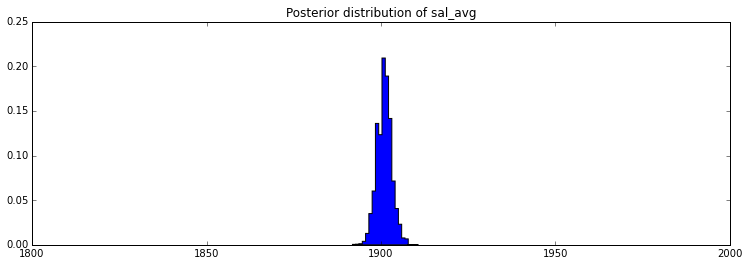

In [85]:
figsize(12.5, 4)
plt.title("Posterior distribution of sal_avg")
plt.hist(mcmc.trace("sal_avg")[:], bins=20, histtype="stepfilled", normed=True)
plt.legend()
plt.xlim((1800, 2000))
print (mcmc.trace("sal_avg")[:].mean())

9.22810481658


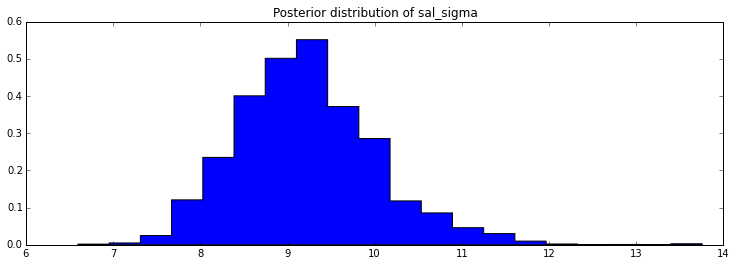

In [98]:

plt.title("Posterior distribution of sal_sigma")
plt.hist(mcmc.trace("sal_sigma")[:], bins=20, histtype="stepfilled", normed=True)
plt.legend()
print (mcmc.trace("sal_sigma")[:].mean())

On ajoute un variable, 1 fois tous les douze mois

In [180]:
sample_with_bonus = amounts.copy()
sample_with_bonus[3] += 2000
sample_with_bonus[15] += 1900
print sample_with_bonus

[ 1902.78520466  1892.21753753  1896.97676198  3906.48332575  1885.55296301
  1886.54734412  1893.97115165  1896.92753714  1909.44920136  1911.59882986
  1907.58514377  1909.79798249  1884.99625492  1905.93182939  1894.64232463
  3815.38787202  1916.09432704  1893.88295789  1898.01100507  1895.36520309
  1901.50381578  1912.38504063  1904.01988166  1903.63721435]


In [181]:
bonus_month = pm.DiscreteUniform("bonus_month", lower = 0, upper = 11)
print bonus_month.random(), bonus_month.random()
bonus_percent = pm.Uniform("bonus_percent", lower = 0.3, upper = 2.)
sal_avg = pm.Normal("sal_avg", mu = 2500., tau = 1e-6)
sal_sigma = pm.Uniform("sal_sigma", 0, 20)

@pm.deterministic
def bonus (bonus_percent = bonus_percent, sample_length = sample_length, bonus_month = bonus_month):
    return [((month % 12) == bonus_month) * bonus_percent for month in np.arange(sample_length)]

print bonus, bonus.dtype, bonus_month, bonus.value

total_salary = pm.Normal("total_salary", mu = sal_avg * (np.array([1.] * sample_length) + bonus), tau = 1/sal_sigma**2,
                         value = sample_with_bonus, observed = True)

print total_salary.random()

mcmc = pm.MCMC([bonus_month, bonus_percent, sal_avg, sal_sigma, total_salary])
mcmc.sample(10000,1000)

0 10
bonus object bonus_month [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.68696219697133132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.68696219697133132, 0.0]
[ 2046.70875869  2040.25316932  2040.74152868  2043.51699369  2046.74661732
  2040.90441973  2029.76712402  2044.86087421  2027.30887079  2037.34477832
  3440.48700128  2027.66558364  2042.90593127  2039.71061443  2043.53573151
  2046.69252334  2037.88987278  2033.84222182  2042.22263974  2038.03098313
  2037.08320147  2030.18998203  3440.8764362   2039.57870453]
 [-----------------100%-----------------] 10000 of 10000 complete in 3.8 sec

1901.06153772


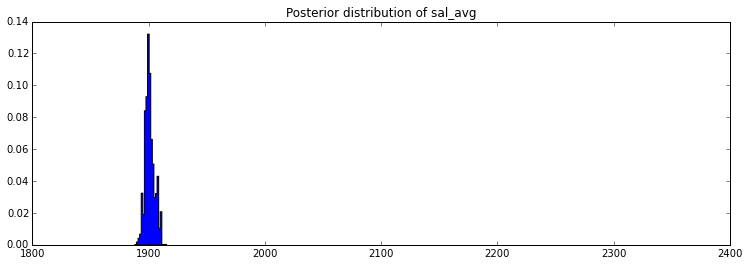

In [182]:
figsize(12.5, 4)
plt.title("Posterior distribution of sal_avg")
plt.hist(mcmc.trace("sal_avg")[:], bins=20, histtype="stepfilled", normed=True)
plt.legend()
plt.xlim((1800, 2400))
print (mcmc.trace("sal_avg")[:].mean())

1.03079680418


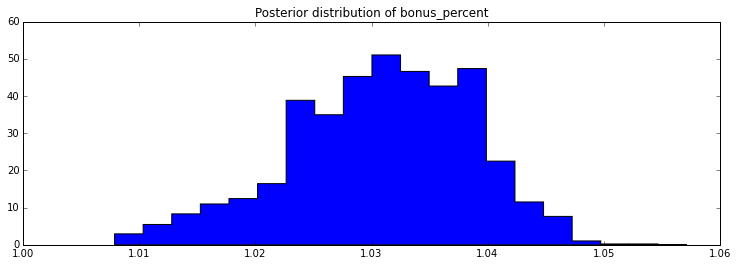

In [183]:
figsize(12.5, 4)
plt.title("Posterior distribution of bonus_percent")
plt.hist(mcmc.trace("bonus_percent")[:], bins=20, histtype="stepfilled", normed=True)
plt.legend()
print (mcmc.trace("bonus_percent")[:].mean())

3.0


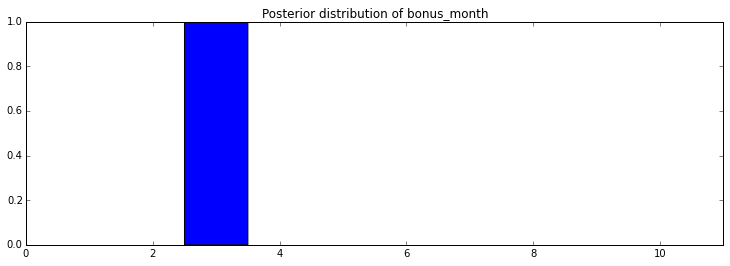

In [184]:
figsize(12.5, 4)
plt.title("Posterior distribution of bonus_month")
plt.hist(mcmc.trace("bonus_month")[:], bins=1, histtype="stepfilled", normed=True)
plt.legend()
plt.xlim((0, 11))
print (mcmc.trace("bonus_month")[:].mean())

In [131]:
print [(3 == i) * 10. for i in np.arange(10)]

[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
